# Introduction

This notebook implement the CNN architecture from "Apparel Classification Using CNN" paper, written by Sri Devi et al, from REVA University.

Download this journal: http://www.ijsrr.co.in/images/full_pdf/1553607966_R1093.pdf

In this paper, there are details that are not explained in the architecture like how many kernels used, and what is the optimizer they used. The accuracy is 90%.

I and my friend try implement it, and we get an accuracy of 94%.

The architecture that we used (with some addition):
 
- Input

- Conv2D (Apply 32 filter of [3x3], activation ReLU)
- Conv2D (Apply 32 filter of [3x3], activation ReLU)
- MaxPooling2D (pool size 2x2)
- Dropout (rate=0.25)

- Conv2D (Apply 64 filter of [3x3], activation ReLU)
- Conv2D (Apply 64 filter of [3x3], activation ReLU)
- MaxPooling2D (pool size 2x2)
- Dropout (rate=0.25)

- Flatten
- Dense (128 units, activation ReLU)
- Batch Normalization
- Dropout (rate=0.5)

- Dense (10 units, activation Softmax)

Optimizer = Adadelta, with learn rate = 1

Batch size = 128

Epochs = 100

# Requirement

## Running using CPU or GPU

We run this notebook using GPU. If you want to run it using GPU, don't forget to check if your GPU is available for use.

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15305654457009516751, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12232092649562419523
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3153655002618135253
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15882446439
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6662678242863971740
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

## Import library

In [2]:
from __future__ import print_function
import pandas as pd
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import os

# Helper libraries
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


## Setting random seed

During development of a model, sometimes it is useful to be able to obtain reproducible results from run to run in order to determine if a change in performance is due to an actual model or data modification, or merely a result of a new random sample. 

[Reference](https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development)

In [3]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Data

Data to use = fashion_mnist

Define data parameters (needed for further code)

In [4]:
num_classes = 10

# image dimensions
img_rows, img_cols = 28, 28

classes = ["Top", "Trouser", "Pullover", "Dress", "Coat",
	"Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

## Get Data

You can get the dataset from:
* keras datasets 
* manually (ex: download from [Kaggle](https://www.kaggle.com/zalando-research/fashionmnist)) and then load it
    

In [5]:
def load_data_from_keras():
    # get data using tf.keras.datasets. Train and test set is automatically split from datasets
    (x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
    return (x_train, y_train), (x_test, y_test)

#if you have download the data, then load it
def load_data_from_file():
    # load the data
    data_train = pd.read_csv('../input/fashion-mnist_train.csv')
    data_test = pd.read_csv('../input/fashion-mnist_test.csv')

    # split the train classes
    x_train = np.array(data_train.iloc[:, 1:])
    y_train = np.array(data_train.iloc[:, 0])

    # split the test classes
    x_test = np.array(data_test.iloc[:, 1:])
    y_test = np.array(data_test.iloc[:, 0])

    # Reshape image from 1D Array to 2D Array
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols)
    
    return (x_train, y_train), (x_test, y_test)

Here, I get the data from kaggle, then load it

In [6]:
(x_train, y_train), (x_test, y_test) = load_data_from_file()

Split train data to train and validation data. Validation data needed to optimize classifier during training.

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=0)

Print the data shape

In [8]:
print("train feature shape = ", x_train.shape)
print("train classes shape = ", y_train.shape)
print("validation feature shape = ", x_val.shape)
print("validation classes shape = ", y_val.shape)
print("test feature shape = ", x_test.shape)
print("test classes shape = ", y_test.shape)

train feature shape =  (54000, 28, 28)
train classes shape =  (54000,)
validation feature shape =  (6000, 28, 28)
validation classes shape =  (6000,)
test feature shape =  (10000, 28, 28)
test classes shape =  (10000,)


## Preprocess

### Keras Backend default image data format convention

Keras backend has default image data format convention

So we reshape our data to adjust with this format convention

In [9]:
if K.image_data_format() == 'channels_first':
    x_train_with_channels = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val_with_channels = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    x_test_with_channels = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train_with_channels = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val_with_channels = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    x_test_with_channels = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
print("train feature shape = ", x_train_with_channels.shape)
print("validation feature shape = ", x_val_with_channels.shape)
print("test feature shape = ", x_test_with_channels.shape)

train feature shape =  (54000, 28, 28, 1)
validation feature shape =  (6000, 28, 28, 1)
test feature shape =  (10000, 28, 28, 1)


### Scale data

Scale data to the range of [0, 1]

In [10]:
x_train_with_channels = x_train_with_channels.astype("float32") / 255.0
x_val_with_channels = x_val_with_channels.astype("float32") / 255.0
x_test_with_channels = x_test_with_channels.astype("float32") / 255.0

### Convert class vectors to binary class matrices (one-hot encode)

In [11]:
y_train_categorical = keras.utils.to_categorical(y_train, num_classes)
y_val_categorical = keras.utils.to_categorical(y_val, num_classes)
y_test_categorical = keras.utils.to_categorical(y_test, num_classes)

# Model

In [12]:
def create_model():
    learn_rate = 1

    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding = 'same'))
    model.add(Conv2D(32, (3, 3), activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(lr=learn_rate),
                  metrics=['accuracy'])
    return model

In [13]:
model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
__________

# Training

## Train the model

Create checkpointing callback, so we can save our model on each epoch

In [14]:
checkpoint_path = 'cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback =  ModelCheckpoint(checkpoint_path,
                                 verbose=1,
                                 save_weights_only=True,
                                 period=1) #  save weights every 1 epochs

Train the model

In [15]:
batch_size = 128
epochs = 100

model_train_history = model.fit(x_train_with_channels, y_train_categorical,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val_with_channels, y_val_categorical),
          callbacks = [cp_callback])

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 10s 179us/step - loss: 0.5279 - acc: 0.8129 - val_loss: 0.3080 - val_acc: 0.8922

Epoch 00001: saving model to cp-0001.ckpt
Epoch 2/100
54000/54000 [==============================] - 5s 95us/step - loss: 0.3402 - acc: 0.8783 - val_loss: 0.2578 - val_acc: 0.9033

Epoch 00002: saving model to cp-0002.ckpt
Epoch 3/100
54000/54000 [==============================] - 5s 94us/step - loss: 0.2918 - acc: 0.8965 - val_loss: 0.2392 - val_acc: 0.9165

Epoch 00003: saving model to cp-0003.ckpt
Epoch 4/100
54000/54000 [==============================] - 5s 94us/step - loss: 0.2640 - acc: 0.9048 - val_loss: 0.2166 - val_acc: 0.9203

Epoch 00004: saving model to cp-0004.ckpt
Epoch 5/100
54000/54000 [==============================] - 5s 94us/step - loss: 0.2458 - acc: 0.9121 - val_loss: 0.2076 - val_acc: 0.9223

Epoch 00005: saving model to cp-0005.ckpt
Epoch 6/100
54000/54000 [===================

54000/54000 [==============================] - 5s 94us/step - loss: 0.0880 - acc: 0.9681 - val_loss: 0.2056 - val_acc: 0.9408

Epoch 00046: saving model to cp-0046.ckpt
Epoch 47/100
54000/54000 [==============================] - 5s 93us/step - loss: 0.0910 - acc: 0.9665 - val_loss: 0.2141 - val_acc: 0.9432

Epoch 00047: saving model to cp-0047.ckpt
Epoch 48/100
54000/54000 [==============================] - 5s 94us/step - loss: 0.0881 - acc: 0.9680 - val_loss: 0.2182 - val_acc: 0.9413

Epoch 00048: saving model to cp-0048.ckpt
Epoch 49/100
54000/54000 [==============================] - 5s 93us/step - loss: 0.0863 - acc: 0.9695 - val_loss: 0.2051 - val_acc: 0.9363

Epoch 00049: saving model to cp-0049.ckpt
Epoch 50/100
54000/54000 [==============================] - 5s 94us/step - loss: 0.0856 - acc: 0.9680 - val_loss: 0.2258 - val_acc: 0.9408

Epoch 00050: saving model to cp-0050.ckpt
Epoch 51/100
54000/54000 [==============================] - 5s 93us/step - loss: 0.0844 - acc: 0.9699 -

54000/54000 [==============================] - 6s 108us/step - loss: 0.0602 - acc: 0.9784 - val_loss: 0.2247 - val_acc: 0.9407

Epoch 00091: saving model to cp-0091.ckpt
Epoch 92/100
54000/54000 [==============================] - 5s 97us/step - loss: 0.0607 - acc: 0.9783 - val_loss: 0.2361 - val_acc: 0.9398

Epoch 00092: saving model to cp-0092.ckpt
Epoch 93/100
54000/54000 [==============================] - 5s 95us/step - loss: 0.0610 - acc: 0.9782 - val_loss: 0.2378 - val_acc: 0.9420

Epoch 00093: saving model to cp-0093.ckpt
Epoch 94/100
54000/54000 [==============================] - 5s 95us/step - loss: 0.0599 - acc: 0.9780 - val_loss: 0.2631 - val_acc: 0.9320

Epoch 00094: saving model to cp-0094.ckpt
Epoch 95/100
54000/54000 [==============================] - 5s 95us/step - loss: 0.0581 - acc: 0.9790 - val_loss: 0.2402 - val_acc: 0.9427

Epoch 00095: saving model to cp-0095.ckpt
Epoch 96/100
54000/54000 [==============================] - 5s 95us/step - loss: 0.0572 - acc: 0.9787 

## Visualize the training result

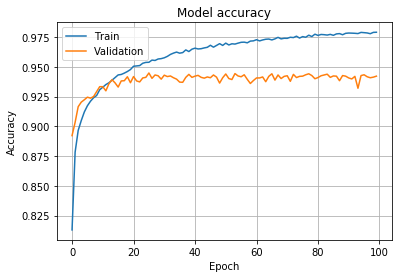

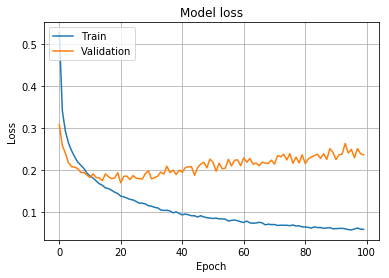

In [16]:
# Plot training & validation accuracy values
plt.plot(model_train_history.history['acc'])
plt.plot(model_train_history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

# Plot training & validation loss values
plt.plot(model_train_history.history['loss'])
plt.plot(model_train_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

## Discussion

From the plot above, we see that the intersection between the train accuracy and the validation accuracy occurred in the 14th epoch with 93.83% validation accuracy and 0.1816 validation loss. After the that epoch, validation accuracy is quite same, overfitted occurred, and the validation loss is increasing a little.

Accuracy of 94% is reached after 17th epoch, but more epochs cause the loss increasing a little. So we can use epoch around 17 to get 93%-94% accuracy and small loss.

# Testing

## Accuracy

On the last epoch (100th epoch), the validation accuracy is 94.32% and validation loss is 0.2624. 

Now we are testing the model which trained until the 100th epoch with the test data.

In [17]:
test_loss, test_acc = model.evaluate(x_test_with_channels, y_test_categorical)
print('Test loss on last epoch:', test_loss)
print('Test accuracy on last epoch:', test_acc)

10000/10000 [==============================] - 1s 79us/step
Test loss on last epoch: 0.22767315539633856
Test accuracy on last epoch: 0.9423


Based on the training results, we also achieved a validation accuracy of 94% in the earlier epoch, which is the 17th epoch. The validation accuracy is 94.17% and validation loss is 0.1809. Also, this validation loss is smaller than the 100th validation loss.

Now we are testing the model which trained until the 17th epoch with the test data.

In [21]:
#load the model which trained until the 17th epoch
model_epoch_17 = create_model()
checkpoint_path = 'cp-0017.ckpt'
model_epoch_17.load_weights(checkpoint_path)

test_loss, test_acc = model_epoch_17.evaluate(x_test_with_channels, y_test_categorical)
print('Test loss on 17th epoch:', test_loss)
print('Test accuracy on 17th epoch:', test_acc)

10000/10000 [==============================] - 1s 104us/step
Test loss on 17th epoch: 0.18753579962179065
Test accuracy on 17th epoch: 0.9356


Based on the results of the previous training, the next earlier epoch which gives a validation accuracy of 94% which is also greater is the 26th epoch. The validation accuracy is 94.48% and validation loss is 0.1806. Also, this validation loss is smaller than the 100th validation loss.

Now we are testing the model which trained until the 26th epoch with the test data.

In [22]:
#load the model which trained until the 26th epoch
model_epoch_26 = create_model()
checkpoint_path = 'cp-0026.ckpt'
model_epoch_26.load_weights(checkpoint_path)

test_loss, test_acc = model_epoch_26.evaluate(x_test_with_channels, y_test_categorical)
print('Test loss on 26th epoch:', test_loss)
print('Test accuracy on 26th epoch:', test_acc)

10000/10000 [==============================] - 1s 102us/step
Test loss on 26th epoch: 0.18112716152593494
Test accuracy on 26th epoch: 0.9424


Based on the testing result, we conclude that we don't need to train the model until the 100th epoch to get a high accuracyy. We can use a small epochs around 26 which provide high accuracy (around 94%), smaller loss, and of course smaller computation time.

Precission, recall, f1-score

In [23]:
prediction_classes = model.predict_classes(x_test_with_channels)
print(classification_report(y_test, prediction_classes))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89      1000
           1       1.00      0.99      1.00      1000
           2       0.93      0.91      0.92      1000
           3       0.96      0.94      0.95      1000
           4       0.93      0.91      0.92      1000
           5       0.99      0.98      0.99      1000
           6       0.81      0.84      0.82      1000
           7       0.97      0.97      0.97      1000
           8       0.99      0.99      0.99      1000
           9       0.97      0.98      0.98      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



## Confusion Matrix

Confusion matrix, without normalization
[[895   0  20   3   0   0  81   0   1   0]
 [  0 995   0   1   0   0   3   0   1   0]
 [ 17   0 910   6  26   0  40   0   1   0]
 [ 13   3   4 945  11   0  24   0   0   0]
 [  1   0  19  18 907   0  54   0   1   0]
 [  0   0   0   0   0 985   0  11   1   3]
 [ 81   0  27  15  29   0 845   0   3   0]
 [  0   0   0   0   0   5   0 969   0  26]
 [  2   1   2   1   1   0   2   1 990   0]
 [  0   0   0   0   0   1   0  17   0 982]]


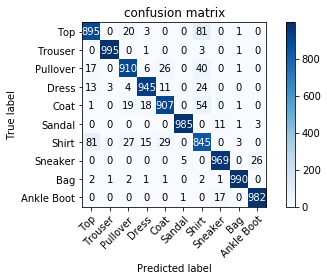

In [24]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Plot confusion matrix
plot_confusion_matrix(y_test, prediction_classes, classes=classes, normalize=False,
                      title='confusion matrix')

## True and False Predicted Visualisation

Create plot function

In [25]:
def plot_image(prediction_probability, image, actual_class, classes):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(image, cmap=plt.cm.binary)
  
  predict_class = np.argmax(prediction_probability)
  if predict_class == actual_class:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(classes[predict_class],
                                100*np.max(prediction_probability),
                                classes[actual_class]),
                                color=color)

def plot_value_array(prediction_probability, actual_class):
  plt.grid(True)
  plt.xticks(range(0,10,1))
  #plt.yticks(range(0,11,0.1))
  thisplot = plt.bar(range(10), prediction_probability, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(prediction_probability)
  
  thisplot[predicted_label].set_color('red')
  thisplot[actual_class].set_color('blue')

Split the true and false predicted image

In [26]:
prediction_classes = model.predict_classes(x_test_with_channels)
true_predict_classes = prediction_classes==y_test
false_predict_classes = prediction_classes!=y_test

#split feature into true and false predicted feature
true_x_test = x_test[true_predict_classes]
false_x_test = x_test[false_predict_classes]

#split classes into true and false predicted classes
true_y_test = y_test[true_predict_classes]
false_y_test = y_test[false_predict_classes]

predictions_probability = model.predict(x_test_with_channels)

#split predictions probability into true and false predicted probability
true_predictions_probability = predictions_probability[true_predict_classes]
false_predictions_probability = predictions_probability[false_predict_classes]

Shows the image that was predicted false

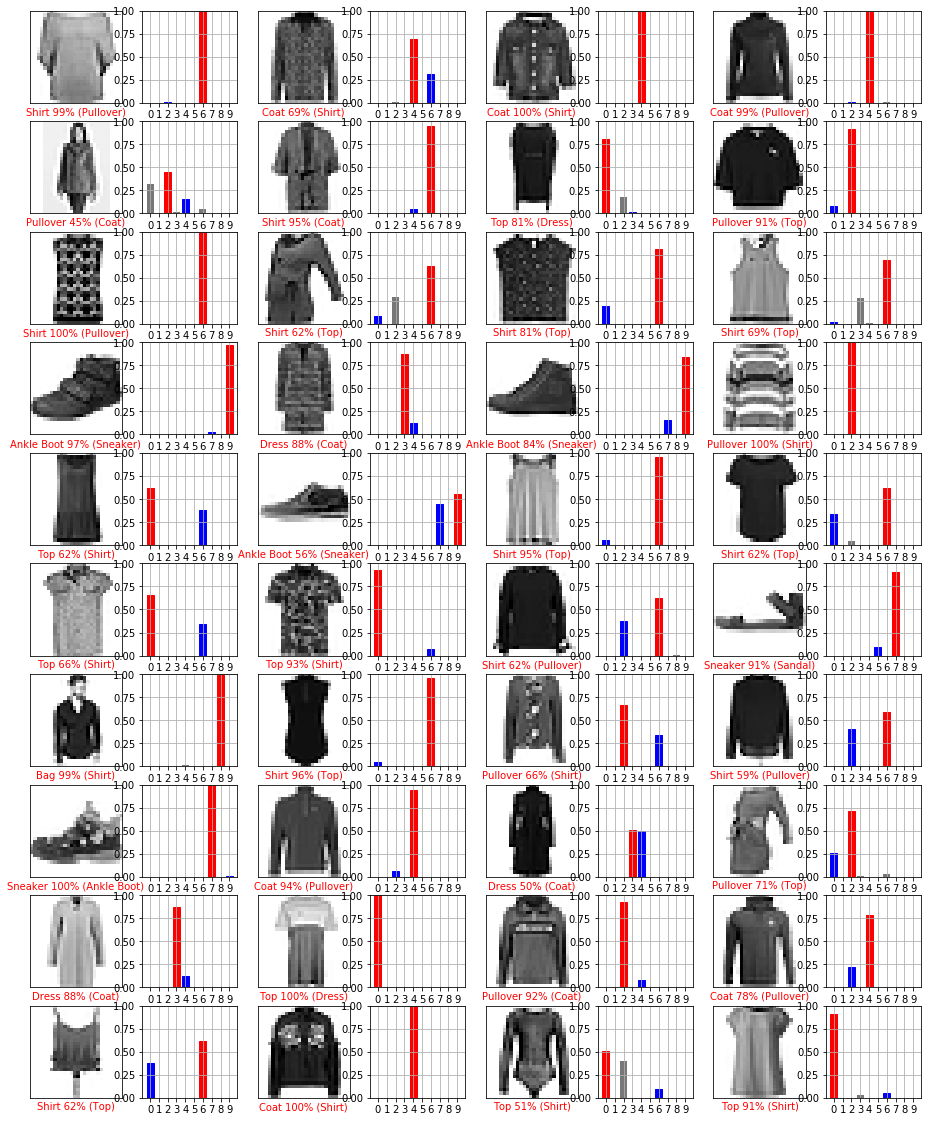

In [27]:
num_rows = 10
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(false_predictions_probability[i], false_x_test[i], false_y_test[i], classes)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(false_predictions_probability[i], false_y_test[i])
plt.show()

Shows the image that was predicted true

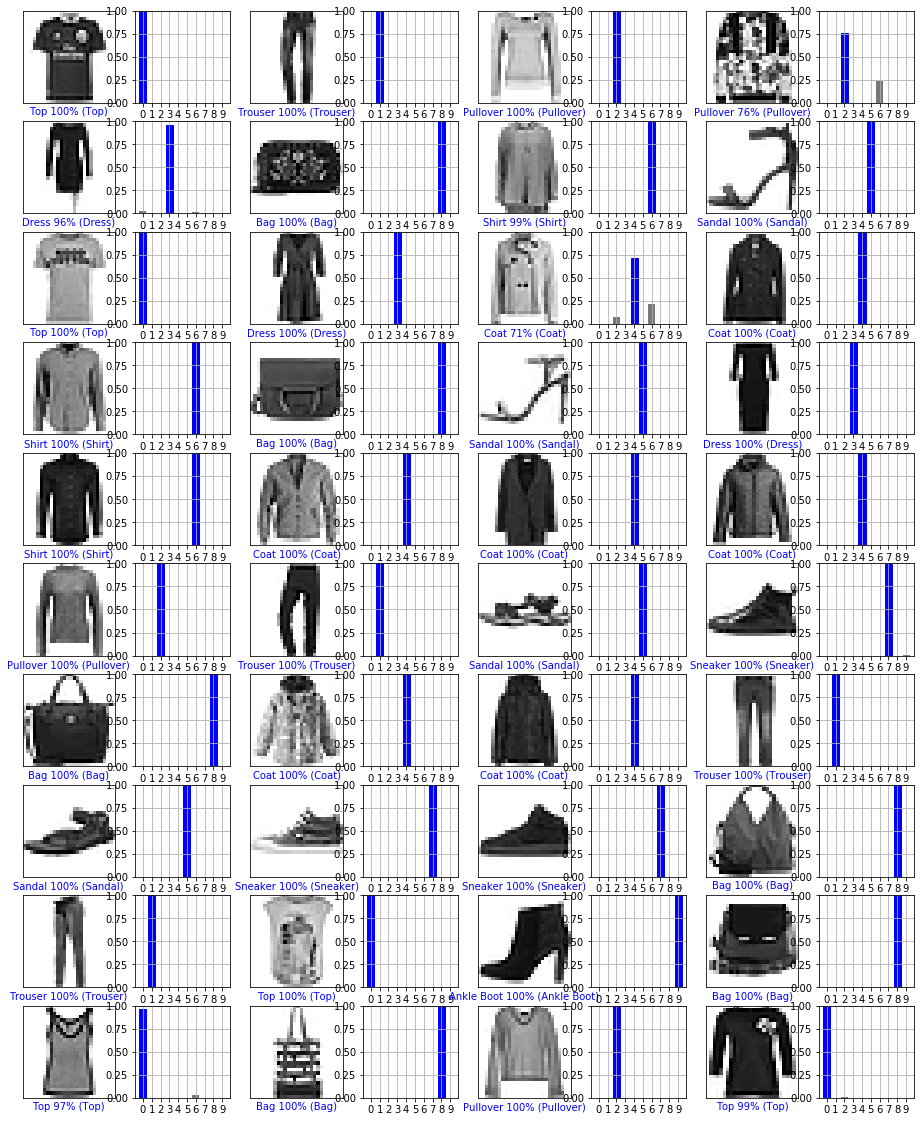

In [28]:
num_rows = 10
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(true_predictions_probability[i], true_x_test[i], true_y_test[i], classes)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(true_predictions_probability[i], true_y_test[i])
plt.show()

## Discussion

Based on the discussion of the testing result before, we conclude that we don't need to train the model until the 100th epoch to get a high accuracy. We can use a small epochs around 26 which provide high accuracy (around 94%), smaller loss, and of course smaller computation time.

Based on the confusion matrix table, it can be seen that the best predicted class is the "trouser" class, because the image is quite different than the other class image.

The worst-predicted class is the "shirt" class. Data which is actually a "shirt" class, is wrongly predicted to be another class. Also data that is actually not a "shirt" class is predicted to be a "shirt" class.

From the visualization of false predicted images, prediction errors occur because the image resolution is to small. This small image resolution causes the image look very similar to other classes image. For example "shirt" which might look very similar to "top", "pullover", and "dress". 

"Shirt" are not wrongly predicted with class like "sandals", "sneakers" and "ankle boot", because they look very different.

# Extras

## Convolution output

We want to show the convolution output of the first image test (data test at index 0)

### Show The Input Image

image shape =  (28, 28)


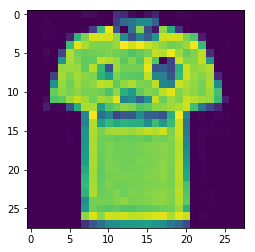

In [29]:
print("image shape = ", x_test_with_channels[0,:,:,0].shape)
plt.imshow(x_test_with_channels[0,:,:,0])
plt.show()

### Convolution 1 output

In [30]:
def show_conv_output(layer_number, data_index):
  #get hidden layer output
  get_i_layer_output = K.function([model.layers[0].input],
                                    [model.layers[layer_number].output])
  layer_output = get_i_layer_output([x_test_with_channels])[0]

  print("conv output shape = ", layer_output.shape)

  (_, _, _, filters) = layer_output.shape
  n_columns = 6
  n_rows = np.math.ceil(filters / n_columns) + 1
  plt.figure(1, figsize=(20,20))
  for i in range(filters):
      plt.subplot(n_rows, n_columns, i+1)
      plt.title(' ' + str(i))
      plt.imshow(layer_output[data_index,:,:,i])

conv output shape =  (10000, 28, 28, 32)


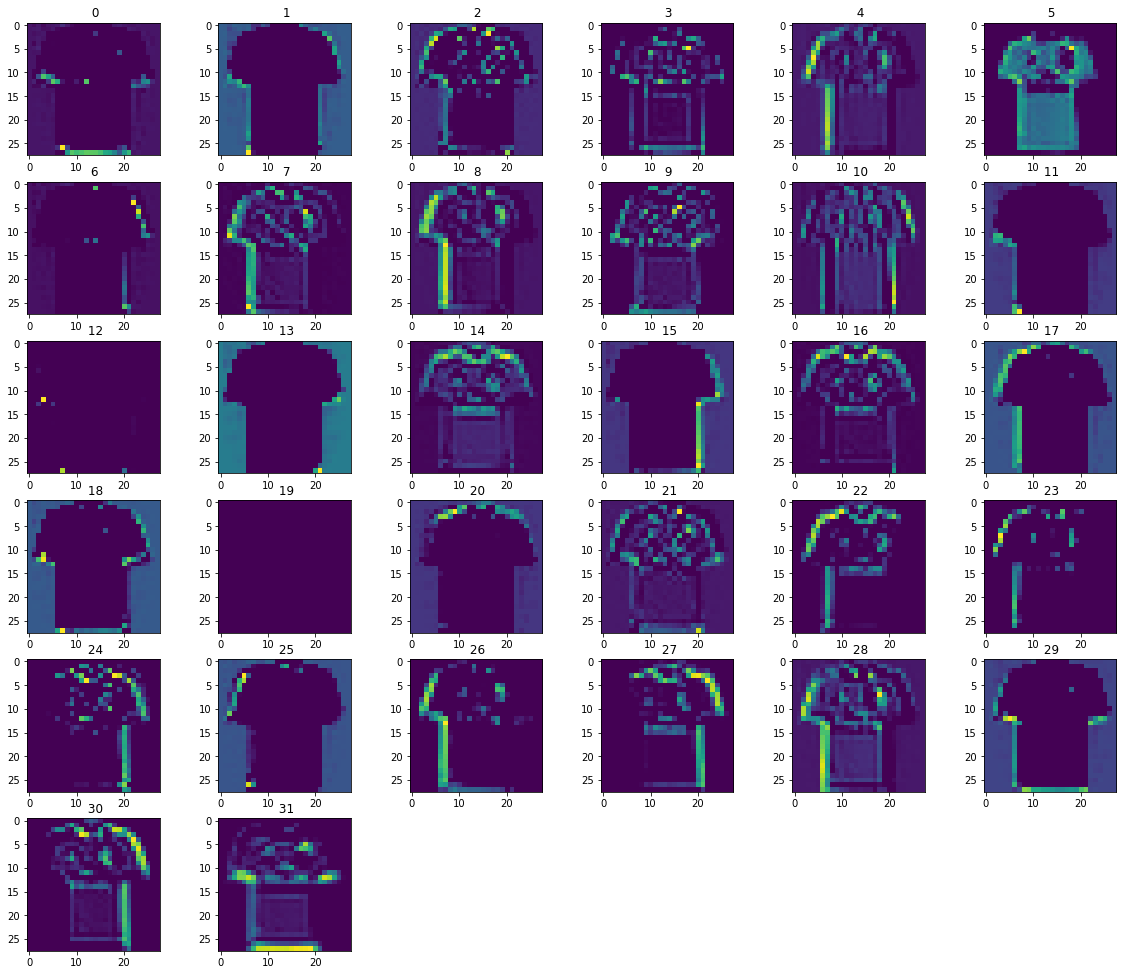

In [31]:
show_conv_output(layer_number=0, data_index=0)

### Convolution 2 output

conv output shape =  (10000, 28, 28, 32)


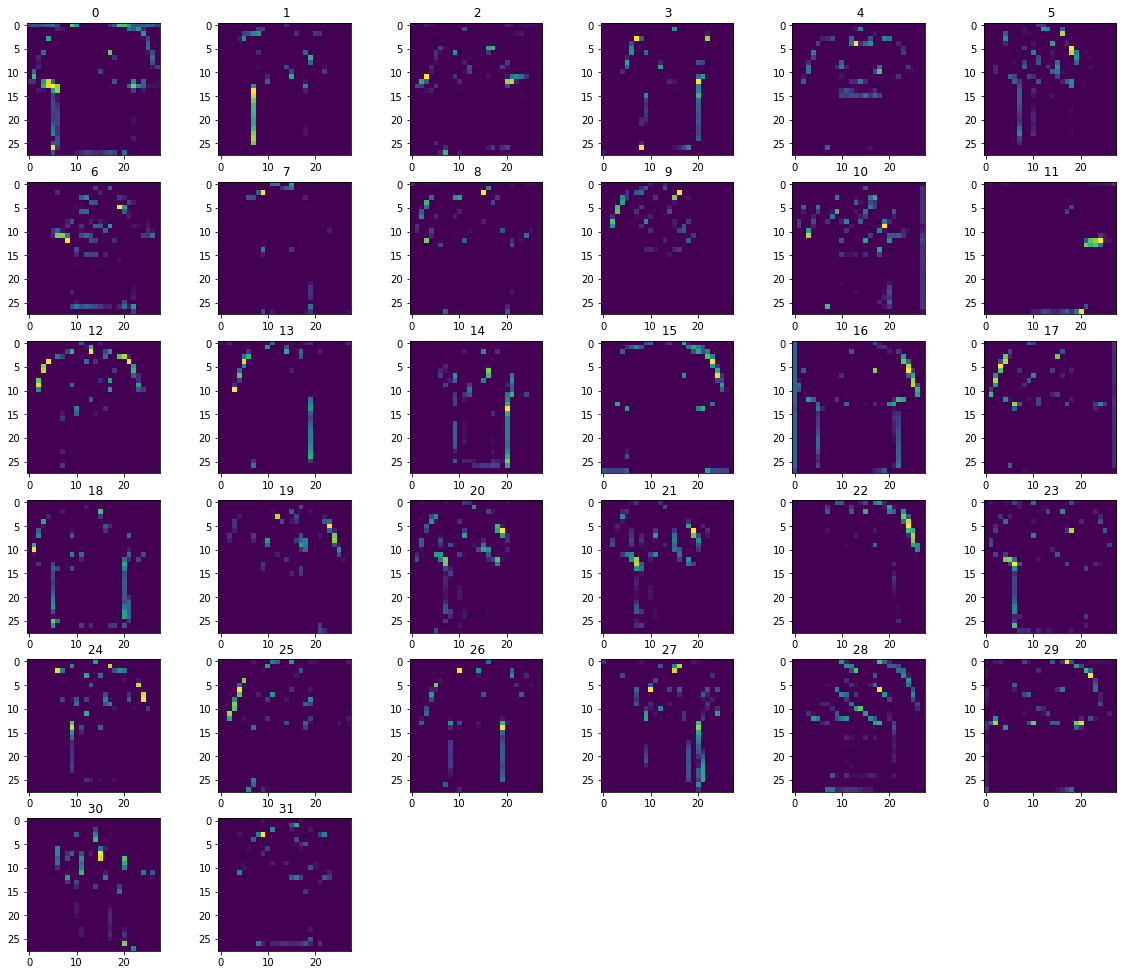

In [32]:
show_conv_output(layer_number=1, data_index=0)

### Convolution 3 output

conv output shape =  (10000, 14, 14, 64)


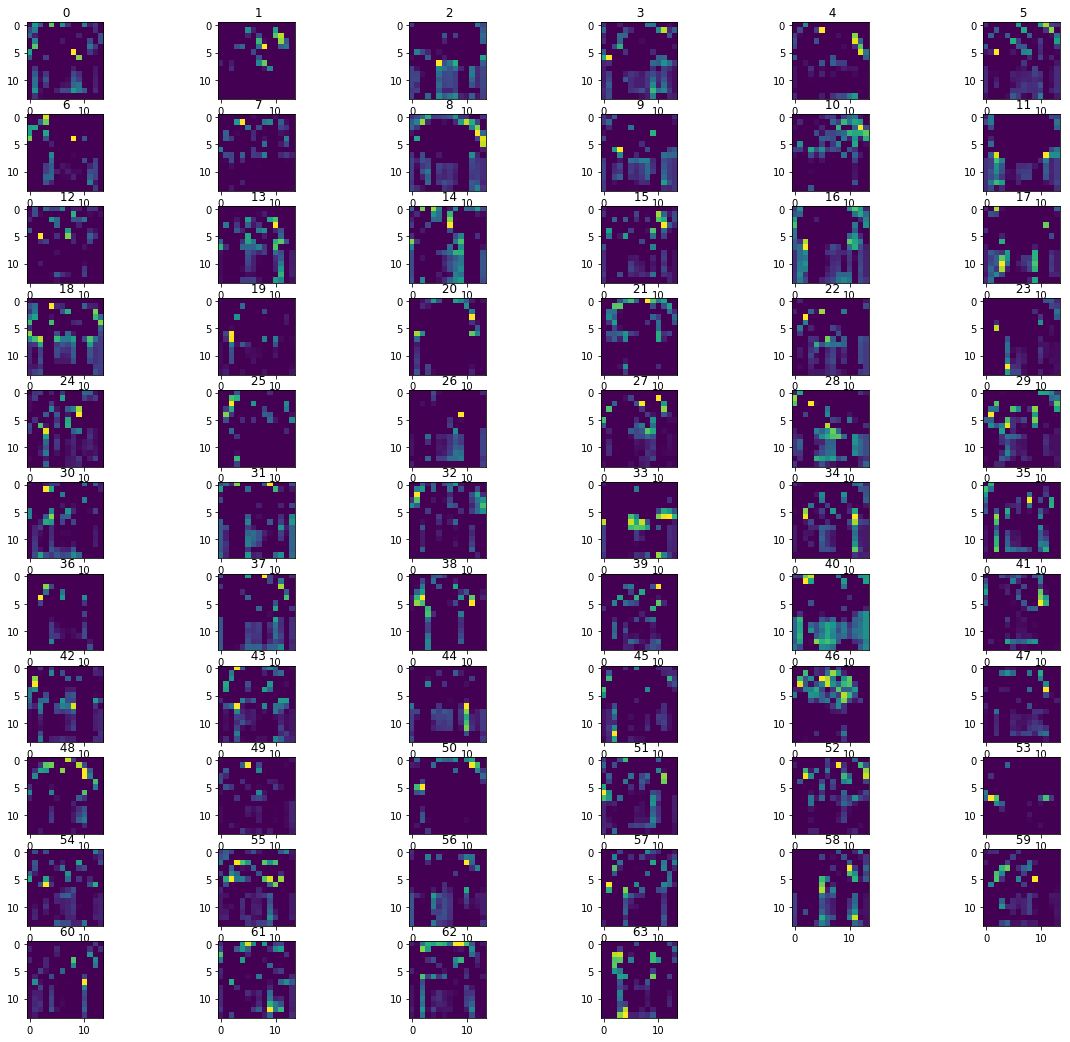

In [33]:
show_conv_output(layer_number=4, data_index=0)

### Convolution 4 output

conv output shape =  (10000, 14, 14, 64)


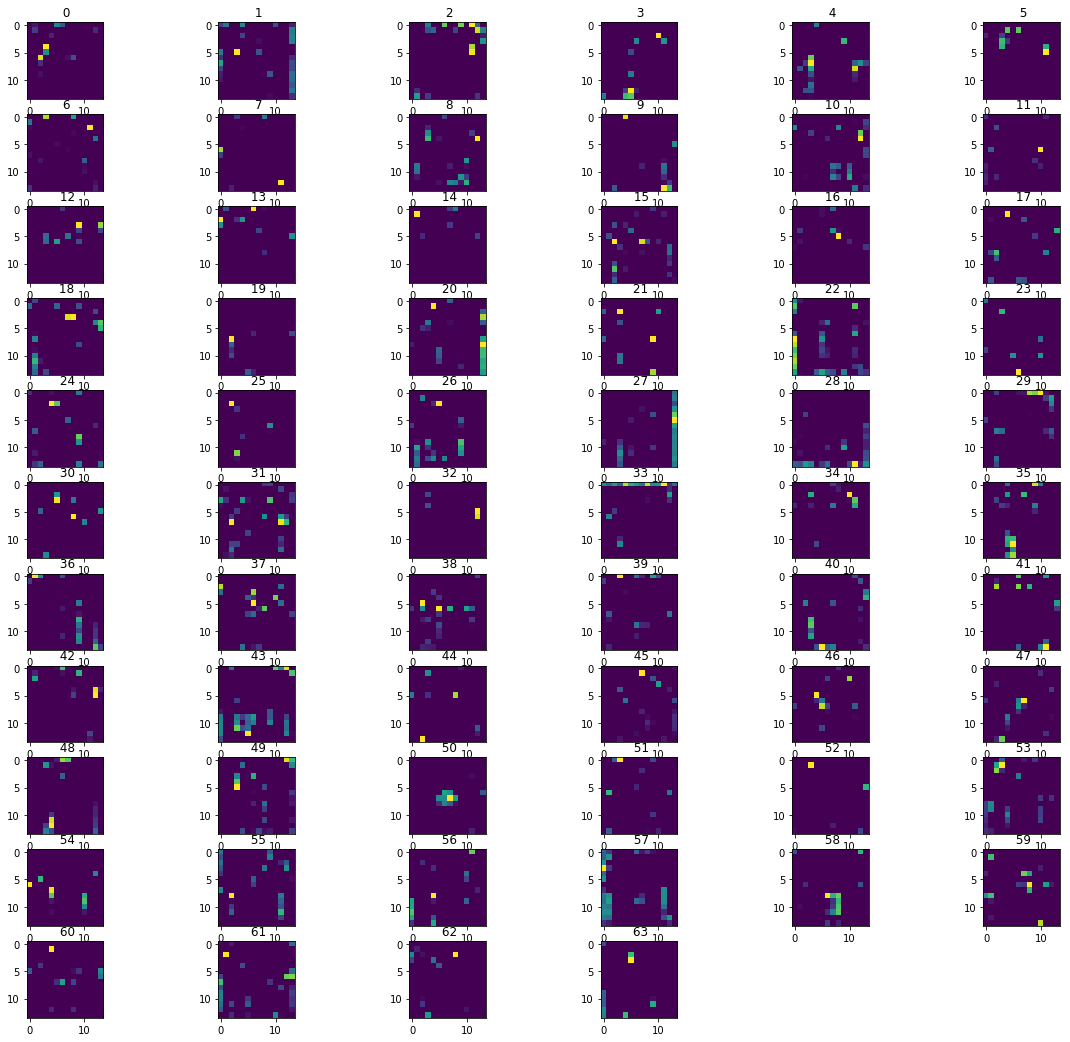

In [34]:
show_conv_output(layer_number=5, data_index=0)